In [1]:
import sys

import meta_dataloader.TCGA

import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import matplotlib.pyplot as plt
from pylab import rcParams

%load_ext autoreload
%autoreload 2

In [2]:
tasks = meta_dataloader.TCGA.TCGAMeta(min_samples_per_class=10)

In [160]:
print(tasks.task_ids)

[('histological_type', 'PRAD'), ('oct_embedded', 'PRAD'), ('biochemical_recurrence', 'PRAD'), ('gender', 'UVM'), ('_EVENT', 'UVM'), ('histological_type', 'UVM'), ('gender', 'READ'), ('_EVENT', 'READ'), ('lymphatic_invasion', 'READ'), ('venous_invasion', 'READ'), ('colon_polyps_present', 'READ'), ('gender', 'HNSC'), ('_EVENT', 'HNSC'), ('oct_embedded', 'HNSC'), ('alcohol_history_documented', 'HNSC'), ('lymphovascular_invasion_present', 'HNSC'), ('_PANCAN_mirna_HNSC', 'HNSC'), ('_PANCAN_DNAMethyl_HNSC', 'HNSC'), ('gender', 'ACC'), ('_EVENT', 'ACC'), ('oct_embedded', 'ACC'), ('clinical_M', 'ACC'), ('necrosis', 'ACC'), ('weiss_venous_invasion', 'ACC'), ('atypical_mitotic_figures', 'ACC'), ('gender', 'LUNG'), ('_EVENT', 'LUNG'), ('oct_embedded', 'LUNG'), ('Expression_Subtype', 'LUNG'), ('_EVENT', 'UCEC'), ('histological_type', 'UCEC'), ('oct_embedded', 'UCEC'), ('hypertension', 'UCEC'), ('pregnancies', 'UCEC'), ('diabetes', 'UCEC'), ('birth_control_pill_history_usage_category', 'UCEC'), ('g

In [3]:
_Event_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == '_EVENT':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        _Event_tasks.append(task)
print(len(_Event_tasks))

30


In [4]:
gender_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'gender':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        gender_tasks.append(task)
print(len(gender_tasks))

29


In [5]:
histological_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'histological_type':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        histological_tasks.append(task)
print(len(histological_tasks))

7


In [6]:
oct_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'oct_embedded':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        oct_tasks.append(task)
print(len(oct_tasks))

25


In [7]:
colon_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'colon_polyps_present':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        colon_tasks.append(task)
print(len(colon_tasks))

3


In [77]:
input_size = task._samples.shape[1]
print(input_size)

20530


In [3]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, seed, input_size, num_classes, num_layers, channels, learning_rate, batch_size, epochs, patience, weight_decay):
        super(MultiLayerPerceptron, self).__init__()
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.weight_decay = weight_decay
        self.num_layers = num_layers
        self.channels = channels
        self.output_size = num_classes
        random.seed(seed)
        torch.manual_seed(seed)
        
        nodes = []
        nodes += channels
        architecture = OrderedDict()
        for i in range(self.num_layers):
            architecture['fc' + str(i)] = nn.Linear(input_size, nodes[i])
            architecture['relu' + str(i)] = torch.nn.ReLU()
            input_size = nodes[i]

        self.features = nn.Sequential(architecture)

        #self.classifier = None
    
    @property
    def criterion(self):
        criterion = F.cross_entropy
        return criterion
    
    @property
    def optimizer(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

    def forward(self, x):
        x = x.view(-1, self.input_size)
        features = self.features(x)
        return features
      

In [4]:
def load_sets(task, valid=False):
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                task._labels, 
                                                                                stratify=task._labels,
                                                                                train_size=50,
                                                                                test_size=100,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                                 )
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

    if valid:
        X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_test, 
                                                                                y_test, 
                                                                                stratify=y_test,
                                                                                train_size=50,
                                                                                test_size=50,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                               )
        valid_set = TensorDataset( Tensor(X_valid), Tensor(y_valid))
        return train_set, valid_set, test_set
    
    return train_set, test_set 

In [5]:
def train(model, dataset, stop_early=False):
    train_loss = []
    criterion = model.criterion
    if type(model).__name__ == "LogisticRegression":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate, weight_decay= model.weight_decay)
     
    if stop_early:
        print("")
    else:
        train_set = dataset
        valid_set = None
 
    for i in range(model.epochs):
        for batch, labels in torch.utils.data.DataLoader(train_set, batch_size=model.batch_size, shuffle=True):
            labels = torch.autograd.Variable(labels.long())
            
            def closure():
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, labels)
                loss.backward()
                return loss
            
            intermediate = optimizer.step(closure)
            loss = intermediate.item()
            train_loss.append(loss)

    return model, loss

In [6]:
def filter_tasks(tasks_list):
    filtered_tasks_sample = []
    for task in tasks_list: 
        try:
            load_sets(task)
            filtered_tasks_sample.append(task)
        except:
            print("Not enough number of samples")
    return filtered_tasks_sample

In [7]:
def get_protoloss(prototypes, query_set, query_labels, num_classes):
    dists = torch.sum((query_set.unsqueeze(1) - prototypes.unsqueeze(0)) ** 2, dim=2)
    protoloss = F.cross_entropy(-dists, query_labels)

    return protoloss

In [8]:
def proto_predict(prototypes, query_set, query_labels, n_classes):  # TODO : a quick fix!
    dists = torch.sum((query_set.unsqueeze(1) - prototypes.unsqueeze(0)) ** 2, dim=2)
    _, index = torch.min(dists, dim=1)
    accuracy = ((index == query_labels).sum().float() / len(query_labels)) * 100
    num_of_correct_preds = (index == query_labels).sum()
    return accuracy, num_of_correct_preds

In [9]:
def sum_batch_metric(batch_loss, batch_acc, loss, acc):
    batch_loss += loss
    batch_acc += acc

    return batch_loss, batch_acc

In [10]:
def div_batch_metric(batch_loss, batch_acc, length):
    batch_loss /= length
    batch_acc /= length

    return batch_loss, batch_acc

In [11]:
def load_batch(dataset, batch_size):
    batch, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size)))

    return batch, labels.long()

In [12]:
 def prepare_protonet(model, support_batch, query_batch, support_labels, query_labels, n_classes, optimizer, taskid):

        support_embedding = model(support_batch)
        prototypes = get_prototypes(support_embedding, support_labels, n_classes)
        query_embedding = model(query_batch)
        loss = get_protoloss(prototypes, query_embedding, query_labels, n_classes)
        #proto_visualization(support_embedding, prototypes, support_labels, loss, taskid)
        acc, num_corrects = proto_predict(prototypes, query_embedding, query_labels, n_classes)

        return loss, acc, num_corrects, support_embedding, query_embedding, support_labels, query_labels

In [13]:
def get_prototypes(support_set, support_labels, num_classes):
    prototypes = torch.zeros((num_classes, support_set.size(1))) 
    index = support_labels.unsqueeze(1).expand_as(support_set)
    prototypes.scatter_add_(0, index, support_set)
    prototypes.div_(float(support_set.size(0)))

    return prototypes

In [14]:
def proto_visualization(data, protos, labels, loss, task_id):
    data = data.detach()
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    proto_np_arr = [p.detach().numpy() for p in protos]
    proto_arr = np.array(proto_np_arr)
    plt.scatter(proto_arr[:,0], proto_arr[:,1], marker='^', s=200, c=[labels[-1], labels[0]])
    plt.title("train labels distribution and the protos for {}" .format(task_id))
    #text(labels=namebank, cex= 0.7)
    plt.grid()
    #logger.save_image(self, tensor=, name=task_dataset.id + ‘’)
    plt.show()

In [15]:
def meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size,num_shots):
    result_seeds_acc = []
    avg_train_loss_list, avg_train_acc_list = [], []
    meta_epoch_train_loss, meta_epoch_train_acc = [], []
    train_dataloader = meta_dataloader.TCGA.TCGAMeta.get_dataloader(meta_train_set, batch_size=meta_batch_size, shuffle=True)
    for meta_epoch in range(meta_epochs):
        for meta_batch in train_dataloader:
            optimizer.zero_grad()
            train_batch_loss, train_batch_acc = 0., 0.
            for task in meta_batch:
                print(task.id)
                support, query = load_sets(task)
                n_classes = len(np.unique(task._labels))
                task_id = task.id
                support_batch, support_labels = load_batch(support, num_shots)
                query_batch, query_labels = load_batch(query, len(query))
                loss, acc, _, sup_emb, qu_emb, sup_lb, qu_lb = prepare_protonet(MLP_model, support_batch, query_batch, support_labels, query_labels, n_classes, optimizer, task.id)
                train_batch_loss, train_batch_acc = sum_batch_metric(train_batch_loss, train_batch_acc, loss, acc)

            train_batch_loss, train_batch_acc = div_batch_metric(train_batch_loss, train_batch_acc, len(meta_batch))
            train_batch_loss.backward(retain_graph=True)
            avg_train_loss_list.append(train_batch_loss)
            avg_train_acc_list.append(train_batch_acc)
            optimizer.step()
            print("Train batch loss: {}".format(train_batch_loss))
            print("Train batch acc: {}".format(train_batch_acc))
            meta_epoch_train_acc.append(train_batch_acc.tolist())     
    avg_train_loss = sum(avg_train_loss_list) / len(avg_train_loss_list)
    avg_train_acc = sum(avg_train_acc_list) / len(avg_train_acc_list)
    print('avg train loss with num_shots = {} : {}' .format(num_shots, avg_train_loss))
    print('avg train acc with num_shots = {} : {}' .format(num_shots, avg_train_acc))
    
    rcParams['figure.figsize'] = 5, 3

    plt.plot(np.arange(len(avg_train_loss_list)),avg_train_loss_list, c='r')
    plt.xlabel('number of epochs')
    plt.ylabel('meta train loss')
    plt.grid()
    plt.ylim(0., 5)
    plt.xlim(0,250)
    plt.show()

    plt.plot(np.arange(len(avg_train_acc_list)),avg_train_acc_list, c='b')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.grid()
    plt.ylim(0., 100)
    plt.xlim(0,250)
    plt.show()
    
    minimum_loss = train_batch_loss.item()
    result_seeds_acc.append(avg_train_acc)
    
    return MLP_model, minimum_loss, avg_train_loss, avg_train_acc, result_seeds_acc

In [16]:
def meta_test(model, meta_test_set, optimizer, meta_batch_size):
    """
        Test the model trained with prototypical learning algorithm
    """
    result_dict = {}
    #device = 'cuda:0' if torch.cuda.is_available() and args.cuda else 'cpu'
    test_dataloader = meta_dataloader.TCGA.TCGAMeta.get_dataloader(meta_test_set, batch_size=meta_batch_size, shuffle=True)
    all_correct_preds = 0.
    all_test_samples = 0.
    for meta_test_batch in test_dataloader:
        for task in meta_test_batch:
            support, query = load_sets(task)
            n_classes = len(np.unique(task._labels))
            print(task.id)
            support_batch, support_labels = load_batch(support, len(support))
            query_batch, query_labels = load_batch(query, len(query))
            model.eval()
            _, acc, num_correct_preds, sup_emb, qu_emb, sup_lb, qu_lb = prepare_protonet(model, support_batch, query_batch, support_labels, query_labels,
                                             n_classes, optimizer, task.id)
            result_dict['(\''+task.id[0]+'\'' + ', ' + '\'' + task.id[-1] + '\')'] = [acc.item()/100.] + [len(support), len(query),  n_classes]
            print("test acc:{}".format(acc.item()))
            all_correct_preds += num_correct_preds.item()
            all_test_samples += len(query)
    avg_acc = (all_correct_preds / all_test_samples) * 100.0
    print("\nAvg test acc:{}" .format(avg_acc))
    return avg_acc, result_dict

In [17]:
#After hyperparameter search (in another notebook)
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0
num_classes = 2
input_size = tasks[0]._samples.shape[1]
seed = 0
meta_batch_size = 5
num_shots = 5 
meta_valid_set = []
embedding_size=100

# Experiment Trained and tested on OCT_Embedded tasks

In [20]:
oct_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'oct_embedded':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        oct_tasks.append(task)
print(len(oct_tasks))

25


In [24]:
valid_tasks = filter_tasks(oct_tasks)
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(len(meta_train_set), len(meta_test_set))

Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
12 4


# Experiment 1: meta-epochs = 60

In [23]:
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0
num_classes =len(np.unique(valid_tasks[0]._labels)
input_size = tasks[0]._samples.shape[1]
seed = 0
meta_batch_size = 5
num_shots = 5 
meta_valid_set = []
embedding_size=100

SyntaxError: invalid syntax (<ipython-input-23-44a173b5dfe5>, line 9)

('oct_embedded', 'BRCA')
('oct_embedded', 'CESC')
('oct_embedded', 'GBMLGG')
('oct_embedded', 'LUNG')
('oct_embedded', 'LGG')
Train batch loss: 0.6731469631195068
Train batch acc: 61.79999923706055
('oct_embedded', 'SARC')
('oct_embedded', 'BLCA')
('oct_embedded', 'PRAD')
('oct_embedded', 'HNSC')
('oct_embedded', 'KIRP')
Train batch loss: 3.478187084197998
Train batch acc: 69.80000305175781
('oct_embedded', 'ESCA')
('oct_embedded', 'LIHC')
Train batch loss: 0.838776707649231
Train batch acc: 38.5
('oct_embedded', 'GBMLGG')
('oct_embedded', 'KIRP')
('oct_embedded', 'LGG')
('oct_embedded', 'PRAD')
('oct_embedded', 'LUNG')
Train batch loss: 0.651591420173645
Train batch acc: 64.4000015258789
('oct_embedded', 'ESCA')
('oct_embedded', 'SARC')
('oct_embedded', 'LIHC')
('oct_embedded', 'BLCA')
('oct_embedded', 'CESC')
Train batch loss: 0.7198218107223511
Train batch acc: 60.400001525878906
('oct_embedded', 'HNSC')
('oct_embedded', 'BRCA')
Train batch loss: 1.2533419132232666
Train batch acc: 

('oct_embedded', 'PRAD')
Train batch loss: 0.531658411026001
Train batch acc: 72.0
('oct_embedded', 'SARC')
('oct_embedded', 'GBMLGG')
('oct_embedded', 'ESCA')
('oct_embedded', 'HNSC')
('oct_embedded', 'KIRP')
Train batch loss: 0.6432645916938782
Train batch acc: 59.599998474121094
('oct_embedded', 'BRCA')
('oct_embedded', 'BLCA')
('oct_embedded', 'CESC')
('oct_embedded', 'LIHC')
('oct_embedded', 'LUNG')
Train batch loss: 0.6285709142684937
Train batch acc: 67.19999694824219
('oct_embedded', 'LGG')
('oct_embedded', 'PRAD')
Train batch loss: 0.5116531252861023
Train batch acc: 74.5
('oct_embedded', 'LUNG')
('oct_embedded', 'PRAD')
('oct_embedded', 'LGG')
('oct_embedded', 'HNSC')
('oct_embedded', 'BRCA')
Train batch loss: 0.6232281923294067
Train batch acc: 66.0
('oct_embedded', 'LIHC')
('oct_embedded', 'KIRP')
('oct_embedded', 'ESCA')
('oct_embedded', 'SARC')
('oct_embedded', 'CESC')
Train batch loss: 0.6387538909912109
Train batch acc: 60.400001525878906
('oct_embedded', 'BLCA')
('oct_

Train batch loss: 0.5871404409408569
Train batch acc: 68.80000305175781
('oct_embedded', 'SARC')
('oct_embedded', 'HNSC')
Train batch loss: 0.5289838910102844
Train batch acc: 69.5
('oct_embedded', 'KIRP')
('oct_embedded', 'LIHC')
('oct_embedded', 'PRAD')
('oct_embedded', 'LGG')
('oct_embedded', 'GBMLGG')
Train batch loss: 0.5837386846542358
Train batch acc: 68.19999694824219
('oct_embedded', 'ESCA')
('oct_embedded', 'HNSC')
('oct_embedded', 'SARC')
('oct_embedded', 'CESC')
('oct_embedded', 'LUNG')
Train batch loss: 0.5917278528213501
Train batch acc: 68.0
('oct_embedded', 'BLCA')
('oct_embedded', 'BRCA')
Train batch loss: 0.503345787525177
Train batch acc: 75.0
('oct_embedded', 'LIHC')
('oct_embedded', 'LGG')
('oct_embedded', 'PRAD')
('oct_embedded', 'HNSC')
('oct_embedded', 'BLCA')
Train batch loss: 0.5359938740730286
Train batch acc: 71.4000015258789
('oct_embedded', 'ESCA')
('oct_embedded', 'GBMLGG')
('oct_embedded', 'CESC')
('oct_embedded', 'SARC')
('oct_embedded', 'LUNG')
Train b

Train batch loss: 0.5423858761787415
Train batch acc: 70.80000305175781
('oct_embedded', 'PRAD')
('oct_embedded', 'CESC')
('oct_embedded', 'SARC')
('oct_embedded', 'BRCA')
('oct_embedded', 'ESCA')
Train batch loss: 0.4556484818458557
Train batch acc: 77.19999694824219
('oct_embedded', 'LGG')
('oct_embedded', 'HNSC')
Train batch loss: 0.6311001181602478
Train batch acc: 64.0
('oct_embedded', 'LUNG')
('oct_embedded', 'CESC')
('oct_embedded', 'HNSC')
('oct_embedded', 'ESCA')
('oct_embedded', 'PRAD')
Train batch loss: 0.5197263956069946
Train batch acc: 74.0
('oct_embedded', 'KIRP')
('oct_embedded', 'GBMLGG')
('oct_embedded', 'SARC')
('oct_embedded', 'LIHC')
('oct_embedded', 'LGG')
Train batch loss: 0.5446959733963013
Train batch acc: 70.19999694824219
('oct_embedded', 'BRCA')
('oct_embedded', 'BLCA')
Train batch loss: 0.44565337896347046
Train batch acc: 77.5
('oct_embedded', 'ESCA')
('oct_embedded', 'LUNG')
('oct_embedded', 'LGG')
('oct_embedded', 'BRCA')
('oct_embedded', 'HNSC')
Train b

('oct_embedded', 'GBMLGG')
Train batch loss: 0.420424222946167
Train batch acc: 78.5
('oct_embedded', 'LUNG')
('oct_embedded', 'KIRP')
('oct_embedded', 'SARC')
('oct_embedded', 'CESC')
('oct_embedded', 'BRCA')
Train batch loss: 0.44854840636253357
Train batch acc: 76.4000015258789
('oct_embedded', 'HNSC')
('oct_embedded', 'ESCA')
('oct_embedded', 'LIHC')
('oct_embedded', 'GBMLGG')
('oct_embedded', 'BLCA')
Train batch loss: 0.47624731063842773
Train batch acc: 76.0
('oct_embedded', 'LGG')
('oct_embedded', 'PRAD')
Train batch loss: 0.42401397228240967
Train batch acc: 75.5
('oct_embedded', 'GBMLGG')
('oct_embedded', 'LGG')
('oct_embedded', 'LIHC')
('oct_embedded', 'CESC')
('oct_embedded', 'LUNG')
Train batch loss: 0.5648905634880066
Train batch acc: 69.0
('oct_embedded', 'BRCA')
('oct_embedded', 'PRAD')
('oct_embedded', 'KIRP')
('oct_embedded', 'SARC')
('oct_embedded', 'HNSC')
Train batch loss: 0.38774022459983826
Train batch acc: 85.19999694824219
('oct_embedded', 'BLCA')
('oct_embedded

('oct_embedded', 'GBMLGG')
Train batch loss: 0.4445553421974182
Train batch acc: 78.0
('oct_embedded', 'LGG')
('oct_embedded', 'PRAD')
('oct_embedded', 'BRCA')
('oct_embedded', 'SARC')
('oct_embedded', 'BLCA')
Train batch loss: 0.3177104592323303
Train batch acc: 87.19999694824219
('oct_embedded', 'LIHC')
('oct_embedded', 'ESCA')
('oct_embedded', 'KIRP')
('oct_embedded', 'CESC')
('oct_embedded', 'LUNG')
Train batch loss: 0.4872778058052063
Train batch acc: 77.19999694824219
('oct_embedded', 'GBMLGG')
('oct_embedded', 'HNSC')
Train batch loss: 0.524308443069458
Train batch acc: 70.5
('oct_embedded', 'BRCA')
('oct_embedded', 'PRAD')
('oct_embedded', 'KIRP')
('oct_embedded', 'HNSC')
('oct_embedded', 'LGG')
Train batch loss: 0.45048826932907104
Train batch acc: 78.19999694824219
('oct_embedded', 'ESCA')
('oct_embedded', 'LIHC')
('oct_embedded', 'GBMLGG')
('oct_embedded', 'LUNG')
('oct_embedded', 'SARC')
Train batch loss: 0.4099937081336975
Train batch acc: 78.80000305175781
('oct_embedded'

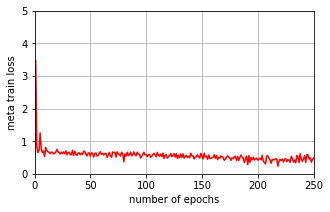

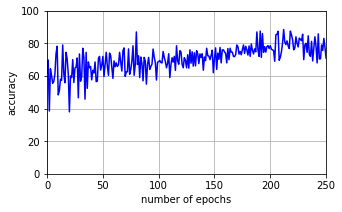

('oct_embedded', 'STAD')
test acc:60.000003814697266
('oct_embedded', 'THCA')
test acc:58.0
('oct_embedded', 'UCEC')
test acc:65.0
('oct_embedded', 'SKCM')
test acc:80.0

Avg test acc:65.75


(65.75,
 {"('oct_embedded', 'STAD')": [0.6000000381469727, 50, 100, 2],
  "('oct_embedded', 'THCA')": [0.58, 50, 100, 2],
  "('oct_embedded', 'UCEC')": [0.65, 50, 100, 2],
  "('oct_embedded', 'SKCM')": [0.8, 50, 100, 2]})

In [25]:
meta_epochs = 90
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size,num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 3: meta-epochs = 50

# Experiment Trained and tested on Gender tasks

In [22]:
gender_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'gender':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        gender_tasks.append(task)

In [31]:
valid_tasks = filter_tasks(gender_tasks)
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(len(meta_train_set), len(meta_test_set))

Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
16 5


# Experiment 1: meta-epochs = 15

In [ ]:
meta_epochs = 60
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size, num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

('gender', 'LUNG')
('gender', 'LIHC')
('gender', 'LUSC')
('gender', 'LGG')
('gender', 'PAAD')
Train batch loss: 0.6644734144210815
Train batch acc: 62.0
('gender', 'KIRP')
('gender', 'HNSC')
('gender', 'LUAD')
('gender', 'BRCA')
('gender', 'LAML')
Train batch loss: 0.5662508606910706
Train batch acc: 67.4000015258789
('gender', 'COAD')
('gender', 'COADREAD')
('gender', 'GBMLGG')
('gender', 'ESCA')
('gender', 'GBM')
Train batch loss: 0.9595249891281128
Train batch acc: 56.79999923706055
('gender', 'BLCA')
Train batch loss: 0.5785601139068604
Train batch acc: 73.0
('gender', 'GBM')
('gender', 'PAAD')
('gender', 'LIHC')
('gender', 'BRCA')
('gender', 'LUAD')
Train batch loss: 0.6248780488967896
Train batch acc: 60.20000076293945
('gender', 'LUNG')
('gender', 'LUSC')
('gender', 'COADREAD')
('gender', 'COAD')
('gender', 'KIRP')
Train batch loss: 0.8961374163627625
Train batch acc: 63.0
('gender', 'LGG')
('gender', 'BLCA')
('gender', 'ESCA')
('gender', 'HNSC')
('gender', 'LAML')
Train batch l

# Experiment 2: meta-epochs = 30

In [94]:
meta_epochs = 30

Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
16 5
('gender', 'LUNG')
('gender', 'LIHC')
('gender', 'LUSC')
('gender', 'LGG')
('gender', 'PAAD')
Train batch loss: 0.6644734144210815
Train batch acc: 62.0
('gender', 'KIRP')
('gender', 'HNSC')
('gender', 'LUAD')
('gender', 'BRCA')
('gender', 'LAML')
Train batch loss: 0.5662508606910706
Train batch acc: 67.4000015258789
('gender', 'COAD')
('gender', 'COADREAD')
('gender', 'GBMLGG')
('gender', 'ESCA')
('gender', 'GBM')
Train batch loss: 0.9595249891281128
Train batch acc: 56.79999923706055
('gender', 'BLCA')
Train batch loss: 0.5785601139068604
Train batch acc: 73.0
('gender', 'GBM')
('gender', 'PAAD')
('gender', 'LIHC')
('gender', 'BRCA')
('gender', 'LUAD')
Train batch loss: 0.6248780488967896
Train batch acc: 60.20000076293945
('gender', 'LUNG')
('gender'

('gender', 'LGG')
('gender', 'ESCA')
Train batch loss: 0.5865082144737244
Train batch acc: 68.0
('gender', 'BRCA')
('gender', 'LUNG')
('gender', 'KIRP')
('gender', 'COADREAD')
('gender', 'PAAD')
Train batch loss: 0.5175517201423645
Train batch acc: 68.80000305175781
('gender', 'GBM')
('gender', 'LAML')
('gender', 'HNSC')
('gender', 'LUAD')
('gender', 'GBMLGG')
Train batch loss: 0.6908666491508484
Train batch acc: 51.599998474121094
('gender', 'LIHC')
Train batch loss: 0.6474397778511047
Train batch acc: 66.0
('gender', 'KIRP')
('gender', 'GBM')
('gender', 'LUNG')
('gender', 'LUSC')
('gender', 'LGG')
Train batch loss: 0.6147204637527466
Train batch acc: 62.79999923706055
('gender', 'PAAD')
('gender', 'LUAD')
('gender', 'LIHC')
('gender', 'LAML')
('gender', 'GBMLGG')
Train batch loss: 0.6763603091239929
Train batch acc: 55.79999923706055
('gender', 'HNSC')
('gender', 'COADREAD')
('gender', 'ESCA')
('gender', 'BLCA')
('gender', 'BRCA')
Train batch loss: 0.504188597202301
Train batch acc: 

Train batch loss: 0.5811184048652649
Train batch acc: 60.400001525878906
('gender', 'LUNG')
('gender', 'LGG')
('gender', 'BRCA')
('gender', 'COAD')
('gender', 'GBM')
Train batch loss: 0.44386616349220276
Train batch acc: 79.4000015258789
('gender', 'LAML')
Train batch loss: 0.6329032182693481
Train batch acc: 76.0
('gender', 'LUSC')
('gender', 'KIRP')
('gender', 'LIHC')
('gender', 'GBM')
('gender', 'ESCA')
Train batch loss: 0.46546420454978943
Train batch acc: 80.5999984741211
('gender', 'GBMLGG')
('gender', 'LAML')
('gender', 'LGG')
('gender', 'COADREAD')
('gender', 'BRCA')
Train batch loss: 0.5204333662986755
Train batch acc: 80.80000305175781
('gender', 'LUAD')
('gender', 'HNSC')
('gender', 'COAD')
('gender', 'PAAD')
('gender', 'LUNG')
Train batch loss: 0.5411646962165833
Train batch acc: 74.0
('gender', 'BLCA')
Train batch loss: 0.38873350620269775
Train batch acc: 79.0
avg train loss with num_shots = 5 : 0.5958385467529297
avg train acc with num_shots = 5 : 66.58165740966797


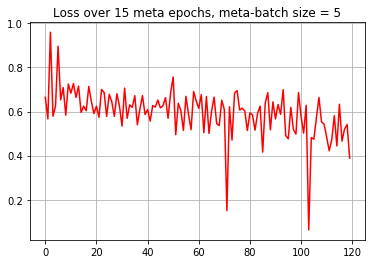

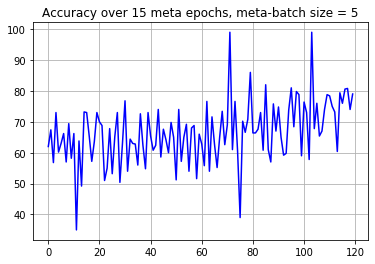

('gender', 'THCA')
test acc:73.0
('gender', 'PCPG')
test acc:60.000003814697266
('gender', 'SARC')
test acc:45.0
('gender', 'SKCM')
test acc:62.0
('gender', 'STAD')
test acc:66.0

Avg test acc:61.199999999999996


(61.199999999999996,
 {"('gender', 'THCA')": [0.73, 50, 100, 2],
  "('gender', 'PCPG')": [0.6000000381469727, 50, 100, 2],
  "('gender', 'SARC')": [0.45, 50, 100, 2],
  "('gender', 'SKCM')": [0.62, 50, 100, 2],
  "('gender', 'STAD')": [0.66, 50, 100, 2]})

In [95]:
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 3: meta-epochs = 50

In [96]:
meta_epochs = 50

Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
16 5
('gender', 'LUNG')
('gender', 'LIHC')
('gender', 'LUSC')
('gender', 'LGG')
('gender', 'PAAD')
Train batch loss: 0.6644734144210815
Train batch acc: 62.0
('gender', 'KIRP')
('gender', 'HNSC')
('gender', 'LUAD')
('gender', 'BRCA')
('gender', 'LAML')
Train batch loss: 0.5662508606910706
Train batch acc: 67.4000015258789
('gender', 'COAD')
('gender', 'COADREAD')
('gender', 'GBMLGG')
('gender', 'ESCA')
('gender', 'GBM')
Train batch loss: 0.9595249891281128
Train batch acc: 56.79999923706055
('gender', 'BLCA')
Train batch loss: 0.5785601139068604
Train batch acc: 73.0
('gender', 'GBM')
('gender', 'PAAD')
('gender', 'LIHC')
('gender', 'BRCA')
('gender', 'LUAD')
Train batch loss: 0.6248780488967896
Train batch acc: 60.20000076293945
('gender', 'LUNG')
('gender'

('gender', 'LGG')
('gender', 'ESCA')
Train batch loss: 0.5865082144737244
Train batch acc: 68.0
('gender', 'BRCA')
('gender', 'LUNG')
('gender', 'KIRP')
('gender', 'COADREAD')
('gender', 'PAAD')
Train batch loss: 0.5175517201423645
Train batch acc: 68.80000305175781
('gender', 'GBM')
('gender', 'LAML')
('gender', 'HNSC')
('gender', 'LUAD')
('gender', 'GBMLGG')
Train batch loss: 0.6908666491508484
Train batch acc: 51.599998474121094
('gender', 'LIHC')
Train batch loss: 0.6474397778511047
Train batch acc: 66.0
('gender', 'KIRP')
('gender', 'GBM')
('gender', 'LUNG')
('gender', 'LUSC')
('gender', 'LGG')
Train batch loss: 0.6147204637527466
Train batch acc: 62.79999923706055
('gender', 'PAAD')
('gender', 'LUAD')
('gender', 'LIHC')
('gender', 'LAML')
('gender', 'GBMLGG')
Train batch loss: 0.6763603091239929
Train batch acc: 55.79999923706055
('gender', 'HNSC')
('gender', 'COADREAD')
('gender', 'ESCA')
('gender', 'BLCA')
('gender', 'BRCA')
Train batch loss: 0.504188597202301
Train batch acc: 

('gender', 'LGG')
('gender', 'BRCA')
('gender', 'COAD')
('gender', 'GBM')
Train batch loss: 0.44386616349220276
Train batch acc: 79.4000015258789
('gender', 'LAML')
Train batch loss: 0.6329032182693481
Train batch acc: 76.0
('gender', 'LUSC')
('gender', 'KIRP')
('gender', 'LIHC')
('gender', 'GBM')
('gender', 'ESCA')
Train batch loss: 0.46546420454978943
Train batch acc: 80.5999984741211
('gender', 'GBMLGG')
('gender', 'LAML')
('gender', 'LGG')
('gender', 'COADREAD')
('gender', 'BRCA')
Train batch loss: 0.5204333662986755
Train batch acc: 80.80000305175781
('gender', 'LUAD')
('gender', 'HNSC')
('gender', 'COAD')
('gender', 'PAAD')
('gender', 'LUNG')
Train batch loss: 0.5411646962165833
Train batch acc: 74.0
('gender', 'BLCA')
Train batch loss: 0.38873350620269775
Train batch acc: 79.0
('gender', 'ESCA')
('gender', 'KIRP')
('gender', 'LAML')
('gender', 'GBMLGG')
('gender', 'HNSC')
Train batch loss: 0.4915253221988678
Train batch acc: 73.19999694824219
('gender', 'PAAD')
('gender', 'BRCA'

('gender', 'ESCA')
Train batch loss: 0.35113224387168884
Train batch acc: 92.80000305175781
('gender', 'BRCA')
('gender', 'LGG')
('gender', 'BLCA')
('gender', 'LIHC')
('gender', 'GBMLGG')
Train batch loss: 0.21781626343727112
Train batch acc: 98.0
('gender', 'HNSC')
('gender', 'LUAD')
('gender', 'LAML')
('gender', 'LUNG')
('gender', 'GBM')
Train batch loss: 0.35454845428466797
Train batch acc: 83.5999984741211
('gender', 'LUSC')
Train batch loss: 0.08368437737226486
Train batch acc: 97.0
('gender', 'LUAD')
('gender', 'LAML')
('gender', 'GBMLGG')
('gender', 'LGG')
('gender', 'LUSC')
Train batch loss: 0.2727298438549042
Train batch acc: 90.80000305175781
('gender', 'LUNG')
('gender', 'BRCA')
('gender', 'BLCA')
('gender', 'HNSC')
('gender', 'COAD')
Train batch loss: 0.2044755220413208
Train batch acc: 96.0
('gender', 'PAAD')
('gender', 'GBM')
('gender', 'LIHC')
('gender', 'COADREAD')
('gender', 'ESCA')
Train batch loss: 0.3526386320590973
Train batch acc: 92.4000015258789
('gender', 'KIRP

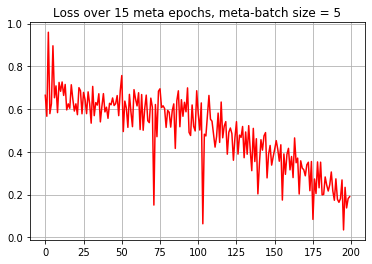

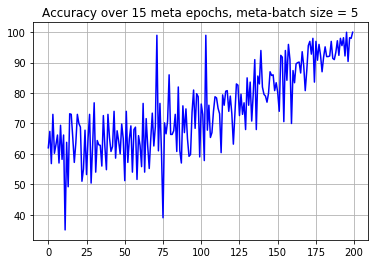

('gender', 'PCPG')
test acc:96.0
('gender', 'STAD')
test acc:75.0
('gender', 'THCA')
test acc:78.0
('gender', 'SKCM')
test acc:68.0
('gender', 'SARC')
test acc:58.999996185302734

Avg test acc:75.2


(75.2,
 {"('gender', 'PCPG')": [0.96, 50, 100, 2],
  "('gender', 'STAD')": [0.75, 50, 100, 2],
  "('gender', 'THCA')": [0.78, 50, 100, 2],
  "('gender', 'SKCM')": [0.68, 50, 100, 2],
  "('gender', 'SARC')": [0.5899999618530274, 50, 100, 2]})

In [97]:
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiments trained on Histological type 

In [19]:
histological_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'histological_type':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        histological_tasks.append(task)
print(len(histological_tasks))

7


In [20]:
valid_tasks = filter_tasks(histological_tasks)
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(len(meta_train_set), len(meta_test_set))

Not enough number of samples
Not enough number of samples
4 1


In [21]:
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0
num_classes = valid_tasks[0].num_classes
input_size = tasks[0]._samples.shape[1]
seed = 0
meta_batch_size = 5
num_shots = 5 
meta_valid_set = []
embedding_size=100

('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'ESCA')
('histological_type', 'PRAD')
Train batch loss: 0.7454478144645691
Train batch acc: 66.5
('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'ESCA')
('histological_type', 'PRAD')
Train batch loss: 5.583873271942139
Train batch acc: 66.5
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'ESCA')
Train batch loss: 0.9600256681442261
Train batch acc: 66.5
('histological_type', 'PRAD')
('histological_type', 'PCPG')
('histological_type', 'ESCA')
('histological_type', 'LGG')
Train batch loss: 0.7971611022949219
Train batch acc: 66.5
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'ESCA')
Train batch loss: 0.793694019317627
Train batch acc: 66.5
('histological_type', 'ESCA')
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 

('histological_type', 'PRAD')
('histological_type', 'PCPG')
Train batch loss: 0.34603583812713623
Train batch acc: 80.75
('histological_type', 'PCPG')
('histological_type', 'LGG')
('histological_type', 'PRAD')
('histological_type', 'ESCA')
Train batch loss: 0.3426915109157562
Train batch acc: 81.0
('histological_type', 'ESCA')
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'LGG')
Train batch loss: 0.3393866717815399
Train batch acc: 81.0
('histological_type', 'ESCA')
('histological_type', 'PCPG')
('histological_type', 'LGG')
('histological_type', 'PRAD')
Train batch loss: 0.33598998188972473
Train batch acc: 81.0
('histological_type', 'PCPG')
('histological_type', 'ESCA')
('histological_type', 'LGG')
('histological_type', 'PRAD')
Train batch loss: 0.3326111435890198
Train batch acc: 81.25
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'ESCA')
Train batch loss: 0.3293367326259613
Train bat

Train batch loss: 0.22854846715927124
Train batch acc: 84.75
('histological_type', 'LGG')
('histological_type', 'PRAD')
('histological_type', 'ESCA')
('histological_type', 'PCPG')
Train batch loss: 0.22637733817100525
Train batch acc: 84.5
('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'ESCA')
Train batch loss: 0.22420771420001984
Train batch acc: 84.5
('histological_type', 'LGG')
('histological_type', 'PRAD')
('histological_type', 'PCPG')
('histological_type', 'ESCA')
Train batch loss: 0.22206929326057434
Train batch acc: 84.75
('histological_type', 'PRAD')
('histological_type', 'ESCA')
('histological_type', 'PCPG')
('histological_type', 'LGG')
Train batch loss: 0.21993044018745422
Train batch acc: 84.75
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'ESCA')
Train batch loss: 0.21782615780830383
Train batch acc: 84.5
('histological_type', 'PCPG')
('histologic

('histological_type', 'PCPG')
Train batch loss: 0.15207567811012268
Train batch acc: 91.75
('histological_type', 'PRAD')
('histological_type', 'PCPG')
('histological_type', 'LGG')
('histological_type', 'ESCA')
Train batch loss: 0.15112510323524475
Train batch acc: 91.75
('histological_type', 'ESCA')
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'PCPG')
Train batch loss: 0.15019431710243225
Train batch acc: 91.75
('histological_type', 'ESCA')
('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'PRAD')
Train batch loss: 0.1492946743965149
Train batch acc: 91.75
('histological_type', 'ESCA')
('histological_type', 'LGG')
('histological_type', 'PRAD')
('histological_type', 'PCPG')
Train batch loss: 0.14841046929359436
Train batch acc: 91.75
('histological_type', 'ESCA')
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'PCPG')
Train batch loss: 0.14753936231136322
Train batch acc: 91.75
('histolog

('histological_type', 'PCPG')
Train batch loss: 0.11129824817180634
Train batch acc: 95.25
('histological_type', 'PCPG')
('histological_type', 'LGG')
('histological_type', 'ESCA')
('histological_type', 'PRAD')
Train batch loss: 0.11004430800676346
Train batch acc: 95.25
('histological_type', 'PRAD')
('histological_type', 'PCPG')
('histological_type', 'LGG')
('histological_type', 'ESCA')
Train batch loss: 0.1088842898607254
Train batch acc: 95.25
('histological_type', 'ESCA')
('histological_type', 'LGG')
('histological_type', 'PRAD')
('histological_type', 'PCPG')
Train batch loss: 0.10770609229803085
Train batch acc: 95.25
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'ESCA')
Train batch loss: 0.10653264075517654
Train batch acc: 95.25
('histological_type', 'ESCA')
('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'PRAD')
Train batch loss: 0.10518024861812592
Train batch acc: 95.25
('histolog

('histological_type', 'ESCA')
('histological_type', 'PRAD')
('histological_type', 'PCPG')
Train batch loss: 0.0535910502076149
Train batch acc: 97.25
('histological_type', 'PRAD')
('histological_type', 'ESCA')
('histological_type', 'LGG')
('histological_type', 'PCPG')
Train batch loss: 0.0529402494430542
Train batch acc: 97.25
('histological_type', 'LGG')
('histological_type', 'ESCA')
('histological_type', 'PRAD')
('histological_type', 'PCPG')
Train batch loss: 0.0522008016705513
Train batch acc: 97.25
('histological_type', 'ESCA')
('histological_type', 'PCPG')
('histological_type', 'LGG')
('histological_type', 'PRAD')
Train batch loss: 0.051335204392671585
Train batch acc: 97.25
('histological_type', 'PRAD')
('histological_type', 'LGG')
('histological_type', 'PCPG')
('histological_type', 'ESCA')
Train batch loss: 0.05075976997613907
Train batch acc: 97.25
('histological_type', 'ESCA')
('histological_type', 'PCPG')
('histological_type', 'PRAD')
('histological_type', 'LGG')
Train batch 

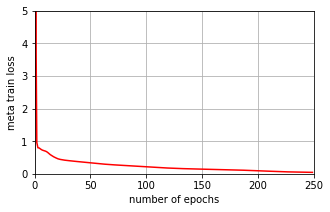

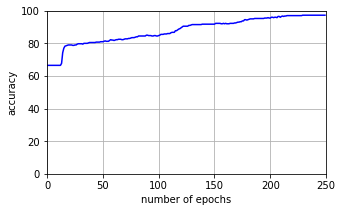

('histological_type', 'UCEC')
test acc:62.0

Avg test acc:62.0


(62.0, {"('histological_type', 'UCEC')": [0.62, 50, 100, 3]})

In [25]:
meta_epochs = 250
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size, num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiments trained on _EVENT tasks

In [18]:
_Event_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == '_EVENT':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        _Event_tasks.append(task)

In [19]:
valid_tasks = filter_tasks(_Event_tasks)
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(len(meta_train_set), len(meta_test_set))

Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples
18 5


In [39]:
#After hyperparameter search (in another notebook)
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0
input_size = tasks[0]._samples.shape[1]
num_classes = valid_tasks[0].num_classes
seed = 0
meta_batch_size = 5
num_shots = 5 
meta_valid_set = []
embedding_size=100

# Experiment 1: meta-epochs = 15

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
Train batch loss: 0.6876407861709595
Train batch acc: 66.0
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
Train batch loss: 0.7228564620018005
Train batch acc: 66.0
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
Train batch loss: 0.6597070693969727
Train batch acc: 59.79999923706055
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 0.9725940227508545
Train batch acc: 70.33333587646484
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
Train batch loss: 0.7059070467948914
Train batch acc: 64.5999984741211
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
Train batch loss: 0.7309738993644714
Train batch acc: 63.0
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD'

('_EVENT', 'GBM')
('_EVENT', 'OV')
('_EVENT', 'LUAD')
Train batch loss: 0.6382259130477905
Train batch acc: 66.0
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'PAAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
Train batch loss: 0.6253105401992798
Train batch acc: 66.5999984741211
('_EVENT', 'HNSC')
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
Train batch loss: 0.646843433380127
Train batch acc: 56.0
('_EVENT', 'GBMLGG')
('_EVENT', 'CESC')
('_EVENT', 'COADREAD')
('_EVENT', 'HNSC')
('_EVENT', 'OV')
Train batch loss: 0.6155372858047485
Train batch acc: 66.19999694824219
('_EVENT', 'PAAD')
('_EVENT', 'LAML')
('_EVENT', 'COAD')
('_EVENT', 'BRCA')
('_EVENT', 'LUNG')
Train batch loss: 0.6341040134429932
Train batch acc: 65.80000305175781
('_EVENT', 'BLCA')
('_EVENT', 'LIHC')
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
('_EVENT', 'LUSC')
Train batch loss: 0.6703915596008301
Train batch acc: 60.20000076293945
('_EVENT', 'LGG')
('_EVENT', 'ESCA')
('_EVENT', 'KIRP')
Train batch loss: 0.528201162815094
Train b

Train batch loss: 0.5476509928703308
Train batch acc: 70.19999694824219
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
('_EVENT', 'LUAD')
Train batch loss: 0.5826191902160645
Train batch acc: 65.0
('_EVENT', 'LGG')
('_EVENT', 'COAD')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'BRCA')
Train batch loss: 0.5110199451446533
Train batch acc: 74.5999984741211
('_EVENT', 'LUNG')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
('_EVENT', 'LUSC')
('_EVENT', 'BLCA')
Train batch loss: 0.6673194169998169
Train batch acc: 60.599998474121094
('_EVENT', 'PAAD')
('_EVENT', 'OV')
('_EVENT', 'LAML')
('_EVENT', 'LIHC')
('_EVENT', 'COADREAD')
Train batch loss: 0.6303912997245789
Train batch acc: 64.19999694824219
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
('_EVENT', 'GBMLGG')
Train batch loss: 0.5661845803260803
Train batch acc: 76.66666412353516
('_EVENT', 'LAML')
('_EVENT', 'HNSC')
('_EVENT', 'COADREAD')
('_EVENT', 'BLCA')
('_EVENT', 'OV')
Train batch loss: 0.6312653422355652
Train batch acc: 61.0
('_EVENT', 'CESC')
('_EVE

('_EVENT', 'BRCA')
('_EVENT', 'PAAD')
('_EVENT', 'CESC')
Train batch loss: 0.5646708607673645
Train batch acc: 74.19999694824219
('_EVENT', 'OV')
('_EVENT', 'HNSC')
('_EVENT', 'LGG')
('_EVENT', 'KIRP')
('_EVENT', 'COADREAD')
Train batch loss: 0.5158319473266602
Train batch acc: 70.19999694824219
('_EVENT', 'ESCA')
('_EVENT', 'BLCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'LAML')
('_EVENT', 'LUSC')
Train batch loss: 0.6506973505020142
Train batch acc: 61.599998474121094
('_EVENT', 'COAD')
('_EVENT', 'LUAD')
('_EVENT', 'LIHC')
Train batch loss: 0.5072082877159119
Train batch acc: 74.66666412353516
('_EVENT', 'COAD')
('_EVENT', 'ESCA')
('_EVENT', 'BLCA')
('_EVENT', 'LAML')
('_EVENT', 'LIHC')
Train batch loss: 0.584757924079895
Train batch acc: 69.4000015258789
('_EVENT', 'GBMLGG')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
('_EVENT', 'HNSC')
Train batch loss: 0.6207619309425354
Train batch acc: 64.19999694824219
('_EVENT', 'COADREAD')
('_EVENT', 'BRCA')
('_EVENT', 'KIRP')
('_EVENT'

('_EVENT', 'LGG')
Train batch loss: 0.48154783248901367
Train batch acc: 75.80000305175781
('_EVENT', 'LAML')
('_EVENT', 'PAAD')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'ESCA')
Train batch loss: 0.5535715222358704
Train batch acc: 73.4000015258789
('_EVENT', 'HNSC')
('_EVENT', 'LIHC')
('_EVENT', 'LUAD')
Train batch loss: 0.520396888256073
Train batch acc: 72.33333587646484
('_EVENT', 'PAAD')
('_EVENT', 'GBMLGG')
('_EVENT', 'LUAD')
('_EVENT', 'COADREAD')
('_EVENT', 'LUSC')
Train batch loss: 0.5011681914329529
Train batch acc: 73.19999694824219
('_EVENT', 'LUNG')
('_EVENT', 'GBM')
('_EVENT', 'LIHC')
('_EVENT', 'HNSC')
('_EVENT', 'KIRP')
Train batch loss: 0.5051733255386353
Train batch acc: 76.0
('_EVENT', 'OV')
('_EVENT', 'LGG')
('_EVENT', 'BRCA')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
Train batch loss: 0.516315221786499
Train batch acc: 74.0
('_EVENT', 'LAML')
('_EVENT', 'COAD')
('_EVENT', 'BLCA')
Train batch loss: 0.5130890011787415
Train batch acc: 74.33333587646484
('_EVENT', 

Train batch loss: 0.6225364208221436
Train batch acc: 65.33333587646484
('_EVENT', 'OV')
('_EVENT', 'LAML')
('_EVENT', 'LUSC')
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
Train batch loss: 0.48982515931129456
Train batch acc: 75.0
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'ESCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'LIHC')
Train batch loss: 0.41133031249046326
Train batch acc: 81.0
('_EVENT', 'LUNG')
('_EVENT', 'PAAD')
('_EVENT', 'KIRP')
('_EVENT', 'COADREAD')
('_EVENT', 'BRCA')
Train batch loss: 0.3963201940059662
Train batch acc: 81.4000015258789
('_EVENT', 'BLCA')
('_EVENT', 'COAD')
('_EVENT', 'HNSC')
Train batch loss: 0.5335392355918884
Train batch acc: 72.33333587646484
('_EVENT', 'HNSC')
('_EVENT', 'OV')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
('_EVENT', 'BLCA')
Train batch loss: 0.5868573784828186
Train batch acc: 69.19999694824219
('_EVENT', 'LGG')
('_EVENT', 'KIRP')
('_EVENT', 'BRCA')
('_EVENT', 'PAAD')
('_EVENT', 'GBMLGG')
Train batch loss: 0.35884708166122437
Train batch acc: 83.19

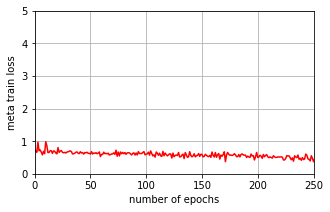

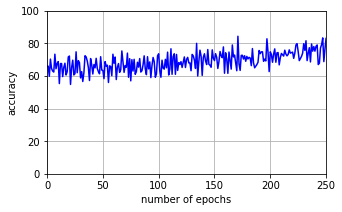

('_EVENT', 'SARC')
test acc:62.0
('_EVENT', 'THCA')
test acc:97.0
('_EVENT', 'STAD')
test acc:58.999996185302734
('_EVENT', 'SKCM')
test acc:57.0
('_EVENT', 'UCEC')
test acc:79.0

Avg test acc:70.8


(70.8,
 {"('_EVENT', 'SARC')": [0.62, 50, 100, 2],
  "('_EVENT', 'THCA')": [0.97, 50, 100, 2],
  "('_EVENT', 'STAD')": [0.5899999618530274, 50, 100, 2],
  "('_EVENT', 'SKCM')": [0.57, 50, 100, 2],
  "('_EVENT', 'UCEC')": [0.79, 50, 100, 2]})

In [20]:
meta_epochs = 80
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size,num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 2: meta-epochs = 30

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
Train batch loss: 0.6876407861709595
Train batch acc: 66.0
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
Train batch loss: 0.7228564620018005
Train batch acc: 66.0
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
Train batch loss: 0.6597070693969727
Train batch acc: 59.79999923706055
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 0.9725940227508545
Train batch acc: 70.33333587646484
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
Train batch loss: 0.7059070467948914
Train batch acc: 64.5999984741211
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
Train batch loss: 0.7309738993644714
Train batch acc: 63.0
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD'

Train batch loss: 0.6064149141311646
Train batch acc: 68.80000305175781
('_EVENT', 'LIHC')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'OV')
('_EVENT', 'LUAD')
Train batch loss: 0.6382259130477905
Train batch acc: 66.0
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'PAAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
Train batch loss: 0.6253105401992798
Train batch acc: 66.5999984741211
('_EVENT', 'HNSC')
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
Train batch loss: 0.646843433380127
Train batch acc: 56.0
('_EVENT', 'GBMLGG')
('_EVENT', 'CESC')
('_EVENT', 'COADREAD')
('_EVENT', 'HNSC')
('_EVENT', 'OV')
Train batch loss: 0.6155372858047485
Train batch acc: 66.19999694824219
('_EVENT', 'PAAD')
('_EVENT', 'LAML')
('_EVENT', 'COAD')
('_EVENT', 'BRCA')
('_EVENT', 'LUNG')
Train batch loss: 0.6341040134429932
Train batch acc: 65.80000305175781
('_EVENT', 'BLCA')
('_EVENT', 'LIHC')
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
('_EVENT', 'LUSC')
Train batch loss: 0.6703915596008301
Train batch acc: 60.20

('_EVENT', 'OV')
('_EVENT', 'LIHC')
Train batch loss: 0.6250177621841431
Train batch acc: 64.19999694824219
('_EVENT', 'BRCA')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'COADREAD')
('_EVENT', 'LUNG')
Train batch loss: 0.5476509928703308
Train batch acc: 70.19999694824219
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
('_EVENT', 'LUAD')
Train batch loss: 0.5826191902160645
Train batch acc: 65.0
('_EVENT', 'LGG')
('_EVENT', 'COAD')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'BRCA')
Train batch loss: 0.5110199451446533
Train batch acc: 74.5999984741211
('_EVENT', 'LUNG')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
('_EVENT', 'LUSC')
('_EVENT', 'BLCA')
Train batch loss: 0.6673194169998169
Train batch acc: 60.599998474121094
('_EVENT', 'PAAD')
('_EVENT', 'OV')
('_EVENT', 'LAML')
('_EVENT', 'LIHC')
('_EVENT', 'COADREAD')
Train batch loss: 0.6303912997245789
Train batch acc: 64.19999694824219
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
('_EVENT', 'GBMLGG')
Train batch loss: 0.5661845803260803
Train bat

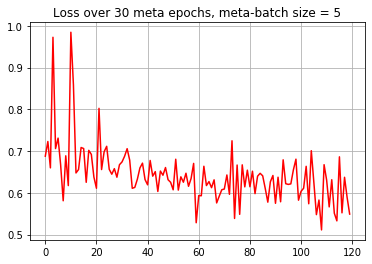

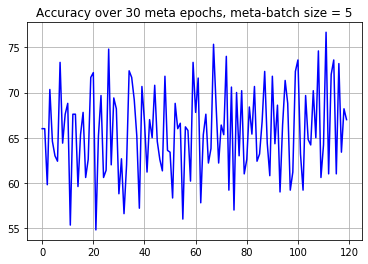

('_EVENT', 'UCEC')
test acc:81.0
('_EVENT', 'STAD')
test acc:60.000003814697266
('_EVENT', 'THCA')
test acc:97.0
('_EVENT', 'SKCM')
test acc:62.0
('_EVENT', 'SARC')
test acc:63.0

Avg test acc:72.6


(72.6,
 {"('_EVENT', 'UCEC')": [0.81, 50, 100, 2],
  "('_EVENT', 'STAD')": [0.6000000381469727, 50, 100, 2],
  "('_EVENT', 'THCA')": [0.97, 50, 100, 2],
  "('_EVENT', 'SKCM')": [0.62, 50, 100, 2],
  "('_EVENT', 'SARC')": [0.63, 50, 100, 2]})

In [52]:
meta_epochs = 250
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 2-1: meta-epochs = 30, meta_batch_size = 10 

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
Train batch loss: 0.6654559373855591
Train batch acc: 66.0
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 1.004037618637085
Train batch acc: 63.75
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
Train batch loss: 0.6879952549934387
Train batch acc: 63.79999923706055
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD')
('_EVENT', 'COAD')
('_EVENT', 'OV')
('_EVENT', 'COADREAD')
('_EVENT', 'KIRP')
Train batch loss: 0.679192304611206
Train batch acc: 66.5
('_EVENT', 'GBMLGG')
('_EVENT', 'LGG')
('_EVENT', 'COAD')
('_EVE

Train batch loss: 0.5985193252563477
Train batch acc: 65.69999694824219
('_EVENT', 'GBM')
('_EVENT', 'HNSC')
('_EVENT', 'GBMLGG')
('_EVENT', 'LUNG')
('_EVENT', 'LGG')
('_EVENT', 'OV')
('_EVENT', 'BRCA')
('_EVENT', 'PAAD')
Train batch loss: 0.6295238137245178
Train batch acc: 65.875
('_EVENT', 'LIHC')
('_EVENT', 'BRCA')
('_EVENT', 'GBM')
('_EVENT', 'COAD')
('_EVENT', 'CESC')
('_EVENT', 'OV')
('_EVENT', 'HNSC')
('_EVENT', 'LUAD')
('_EVENT', 'PAAD')
('_EVENT', 'COADREAD')
Train batch loss: 0.6245797872543335
Train batch acc: 66.80000305175781
('_EVENT', 'BLCA')
('_EVENT', 'LUNG')
('_EVENT', 'LGG')
('_EVENT', 'GBMLGG')
('_EVENT', 'KIRP')
('_EVENT', 'LAML')
('_EVENT', 'LUSC')
('_EVENT', 'ESCA')
Train batch loss: 0.5920132398605347
Train batch acc: 65.0
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
('_EVENT', 'KIRP')
('_EVENT', 'COADREAD')
('_EVENT', 'ESCA')
('_EVENT', 'OV')
('_EVENT', 'PAAD')
('_EVENT', 'GBM')
('_EVENT', 'LIHC')
('_EVENT', 'LAML')
Train batch loss: 0.5996549725532532
Train batch acc

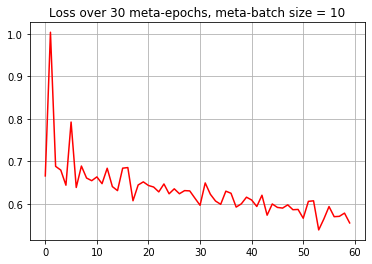

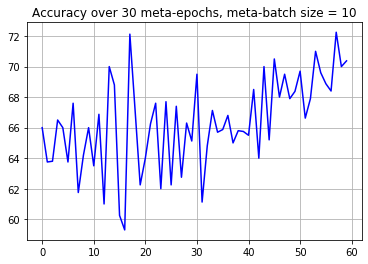

('_EVENT', 'UCEC')
test acc:81.0
('_EVENT', 'STAD')
test acc:62.0
('_EVENT', 'THCA')
test acc:97.0
('_EVENT', 'SKCM')
test acc:54.000003814697266
('_EVENT', 'SARC')
test acc:63.0

Avg test acc:71.39999999999999


(71.39999999999999,
 {"('_EVENT', 'UCEC')": [0.81, 50, 100, 2],
  "('_EVENT', 'STAD')": [0.62, 50, 100, 2],
  "('_EVENT', 'THCA')": [0.97, 50, 100, 2],
  "('_EVENT', 'SKCM')": [0.5400000381469726, 50, 100, 2],
  "('_EVENT', 'SARC')": [0.63, 50, 100, 2]})

In [39]:
meta_epochs = 30
meta_batch_size = 10 
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 2-2: meta-epochs = 30, meta_batch_size = 15 

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
Train batch loss: 0.6654971837997437
Train batch acc: 63.93333435058594
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 1.3139524459838867
Train batch acc: 70.33333587646484
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD')
('_EVENT', 'COAD')
Train batch loss: 0.6830734610557556
Train batch acc: 63.33333206176758
('_EVENT', 'OV')
('_EVENT', 'COADREAD')
('_EVENT', 'KIRP')
Train batch loss: 0.6046627759933472
Train batch acc: 73.33333587646484
('_EVENT', 'GBMLGG')
('_

('_EVENT', 'KIRP')
('_EVENT', 'ESCA')
('_EVENT', 'LIHC')
('_EVENT', 'LUSC')
('_EVENT', 'LAML')
('_EVENT', 'GBM')
('_EVENT', 'HNSC')
('_EVENT', 'GBMLGG')
('_EVENT', 'LUNG')
('_EVENT', 'LGG')
Train batch loss: 0.6523640155792236
Train batch acc: 65.0
('_EVENT', 'OV')
('_EVENT', 'BRCA')
('_EVENT', 'PAAD')
Train batch loss: 0.6666684746742249
Train batch acc: 65.0
('_EVENT', 'LIHC')
('_EVENT', 'BRCA')
('_EVENT', 'GBM')
('_EVENT', 'COAD')
('_EVENT', 'CESC')
('_EVENT', 'OV')
('_EVENT', 'HNSC')
('_EVENT', 'LUAD')
('_EVENT', 'PAAD')
('_EVENT', 'COADREAD')
('_EVENT', 'BLCA')
('_EVENT', 'LUNG')
('_EVENT', 'LGG')
('_EVENT', 'GBMLGG')
('_EVENT', 'KIRP')
Train batch loss: 0.6398526430130005
Train batch acc: 66.80000305175781
('_EVENT', 'LAML')
('_EVENT', 'LUSC')
('_EVENT', 'ESCA')
Train batch loss: 0.6950481534004211
Train batch acc: 56.0
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
('_EVENT', 'KIRP')
('_EVENT', 'COADREAD')
('_EVENT', 'ESCA')
('_EVENT', 'OV')
('_EVENT', 'PAAD')
('_EVENT', 'GBM')
('_EVENT',

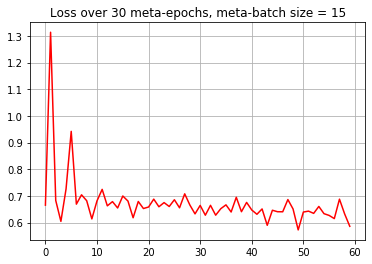

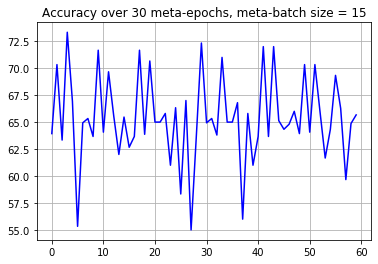

('_EVENT', 'UCEC')
test acc:81.0
('_EVENT', 'STAD')
test acc:61.0
('_EVENT', 'THCA')
test acc:97.0
('_EVENT', 'SKCM')
test acc:52.999996185302734
('_EVENT', 'SARC')
test acc:63.0

Avg test acc:71.0


(71.0,
 {"('_EVENT', 'UCEC')": [0.81, 50, 100, 2],
  "('_EVENT', 'STAD')": [0.61, 50, 100, 2],
  "('_EVENT', 'THCA')": [0.97, 50, 100, 2],
  "('_EVENT', 'SKCM')": [0.5299999618530273, 50, 100, 2],
  "('_EVENT', 'SARC')": [0.63, 50, 100, 2]})

In [40]:
meta_epochs = 30
meta_batch_size = 15 
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 2-3: meta-epochs = 30, meta_batch_size = 20 

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 0.6622505784034729
Train batch acc: 65.0
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD')
('_EVENT', 'COAD')
('_EVENT', 'OV')
('_EVENT', 'COADREAD')
('_EVENT', 'KIRP')
Train batch loss: 0.9266371130943298
Train batch acc: 65.0
('_EVENT', 'GBMLGG')
('_EVENT', 'LGG')
('_EVENT', 'COAD')
('_EVENT', 'LAML')
('_EVENT', 'HNSC')
('_EVENT', 'LUNG')
('_EVENT', 'BRCA')
('_EVENT', 'PAAD')
('_EVENT', 'KIRP')
('_EVENT', 'OV')
('_EV

('_EVENT', 'GBMLGG')
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
('_EVENT', 'LAML')
('_EVENT', 'COAD')
('_EVENT', 'ESCA')
('_EVENT', 'BRCA')
Train batch loss: 0.6181311011314392
Train batch acc: 65.66666412353516
('_EVENT', 'BRCA')
('_EVENT', 'LUNG')
('_EVENT', 'OV')
('_EVENT', 'GBMLGG')
('_EVENT', 'LUSC')
('_EVENT', 'PAAD')
('_EVENT', 'LAML')
('_EVENT', 'LIHC')
('_EVENT', 'LGG')
('_EVENT', 'ESCA')
('_EVENT', 'COAD')
('_EVENT', 'COADREAD')
('_EVENT', 'LUAD')
('_EVENT', 'CESC')
('_EVENT', 'HNSC')
('_EVENT', 'BLCA')
('_EVENT', 'KIRP')
('_EVENT', 'GBM')
Train batch loss: 0.6164080500602722
Train batch acc: 65.72222137451172
('_EVENT', 'LUNG')
('_EVENT', 'GBMLGG')
('_EVENT', 'COADREAD')
('_EVENT', 'LUAD')
('_EVENT', 'BLCA')
('_EVENT', 'LAML')
('_EVENT', 'LUSC')
('_EVENT', 'CESC')
('_EVENT', 'HNSC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'PAAD')
('_EVENT', 'KIRP')
('_EVENT', 'BRCA')
('_EVENT', 'GBM')
('_EVENT', 'ESCA')
('_EVENT', 'OV')
('_EVENT', 'COAD')
Train batch los

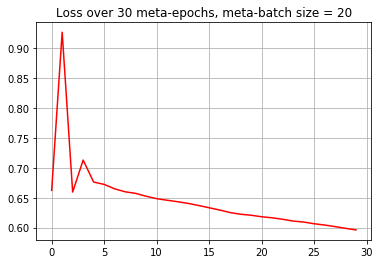

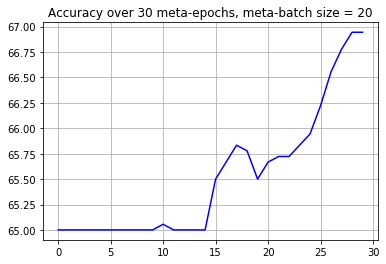

('_EVENT', 'UCEC')
test acc:80.0
('_EVENT', 'STAD')
test acc:61.0
('_EVENT', 'THCA')
test acc:97.0
('_EVENT', 'SKCM')
test acc:58.999996185302734
('_EVENT', 'SARC')
test acc:63.0

Avg test acc:72.0


(72.0,
 {"('_EVENT', 'UCEC')": [0.8, 50, 100, 2],
  "('_EVENT', 'STAD')": [0.61, 50, 100, 2],
  "('_EVENT', 'THCA')": [0.97, 50, 100, 2],
  "('_EVENT', 'SKCM')": [0.5899999618530274, 50, 100, 2],
  "('_EVENT', 'SARC')": [0.63, 50, 100, 2]})

In [42]:
meta_epochs = 30
meta_batch_size = 20 
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

In [ ]:
meta_epochs = 30
meta_batch_size = 30 
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 0.6622505784034729
Train batch acc: 65.0
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD')
('_EVENT', 'COAD')
('_EVENT', 'OV')
('_EVENT', 'COADREAD')
('_EVENT', 'KIRP')
Train batch loss: 0.9266371130943298
Train batch acc: 65.0
('_EVENT', 'GBMLGG')
('_EVENT', 'LGG')
('_EVENT', 'COAD')
('_EVENT', 'LAML')
('_EVENT', 'HNSC')
('_EVENT', 'LUNG')
('_EVENT', 'BRCA')
('_EVENT', 'PAAD')
('_EVENT', 'KIRP')
('_EVENT', 'OV')
('_EV

# Experiment 3: meta-epochs = 40

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
Train batch loss: 0.6876407861709595
Train batch acc: 66.0
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
Train batch loss: 0.7228564620018005
Train batch acc: 66.0
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
Train batch loss: 0.6597070693969727
Train batch acc: 59.79999923706055
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 0.9725940227508545
Train batch acc: 70.33333587646484
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
Train batch loss: 0.7059070467948914
Train batch acc: 64.5999984741211
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
Train batch loss: 0.7309738993644714
Train batch acc: 63.0
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD'

Train batch loss: 0.6064149141311646
Train batch acc: 68.80000305175781
('_EVENT', 'LIHC')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'OV')
('_EVENT', 'LUAD')
Train batch loss: 0.6382259130477905
Train batch acc: 66.0
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'PAAD')
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
Train batch loss: 0.6253105401992798
Train batch acc: 66.5999984741211
('_EVENT', 'HNSC')
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
Train batch loss: 0.646843433380127
Train batch acc: 56.0
('_EVENT', 'GBMLGG')
('_EVENT', 'CESC')
('_EVENT', 'COADREAD')
('_EVENT', 'HNSC')
('_EVENT', 'OV')
Train batch loss: 0.6155372858047485
Train batch acc: 66.19999694824219
('_EVENT', 'PAAD')
('_EVENT', 'LAML')
('_EVENT', 'COAD')
('_EVENT', 'BRCA')
('_EVENT', 'LUNG')
Train batch loss: 0.6341040134429932
Train batch acc: 65.80000305175781
('_EVENT', 'BLCA')
('_EVENT', 'LIHC')
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
('_EVENT', 'LUSC')
Train batch loss: 0.6703915596008301
Train batch acc: 60.20

('_EVENT', 'HNSC')
('_EVENT', 'COADREAD')
('_EVENT', 'LUNG')
Train batch loss: 0.5476509928703308
Train batch acc: 70.19999694824219
('_EVENT', 'LUSC')
('_EVENT', 'LGG')
('_EVENT', 'LUAD')
Train batch loss: 0.5826191902160645
Train batch acc: 65.0
('_EVENT', 'LGG')
('_EVENT', 'COAD')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'BRCA')
Train batch loss: 0.5110199451446533
Train batch acc: 74.5999984741211
('_EVENT', 'LUNG')
('_EVENT', 'ESCA')
('_EVENT', 'CESC')
('_EVENT', 'LUSC')
('_EVENT', 'BLCA')
Train batch loss: 0.6673194169998169
Train batch acc: 60.599998474121094
('_EVENT', 'PAAD')
('_EVENT', 'OV')
('_EVENT', 'LAML')
('_EVENT', 'LIHC')
('_EVENT', 'COADREAD')
Train batch loss: 0.6303912997245789
Train batch acc: 64.19999694824219
('_EVENT', 'GBM')
('_EVENT', 'LUAD')
('_EVENT', 'GBMLGG')
Train batch loss: 0.5661845803260803
Train batch acc: 76.66666412353516
('_EVENT', 'LAML')
('_EVENT', 'HNSC')
('_EVENT', 'COADREAD')
('_EVENT', 'BLCA')
('_EVENT', 'OV')
Train batch loss: 0.631

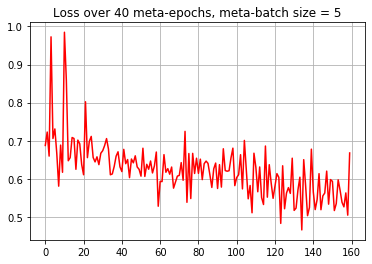

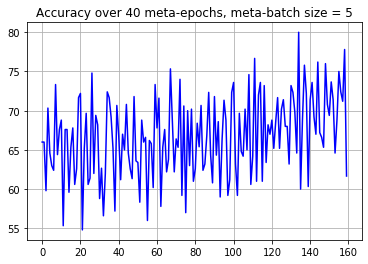

('_EVENT', 'SARC')
test acc:62.0
('_EVENT', 'SKCM')
test acc:55.0
('_EVENT', 'STAD')
test acc:60.000003814697266
('_EVENT', 'THCA')
test acc:97.0
('_EVENT', 'UCEC')
test acc:81.0

Avg test acc:71.0


(71.0,
 {"('_EVENT', 'SARC')": [0.62, 50, 100, 2],
  "('_EVENT', 'SKCM')": [0.55, 50, 100, 2],
  "('_EVENT', 'STAD')": [0.6000000381469727, 50, 100, 2],
  "('_EVENT', 'THCA')": [0.97, 50, 100, 2],
  "('_EVENT', 'UCEC')": [0.81, 50, 100, 2]})

In [22]:
meta_epochs = 70
num_shots = 5
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size, num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

In [ ]:
meta_epochs = 70
num_shots = 5
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size, num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

('_EVENT', 'BRCA')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBM')
('_EVENT', 'LUSC')
('_EVENT', 'LUAD')
Train batch loss: 0.6876407861709595
Train batch acc: 66.0
('_EVENT', 'LUNG')
('_EVENT', 'COADREAD')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'BLCA')
Train batch loss: 0.7228564620018005
Train batch acc: 66.0
('_EVENT', 'OV')
('_EVENT', 'KIRP')
('_EVENT', 'HNSC')
('_EVENT', 'PAAD')
('_EVENT', 'ESCA')
Train batch loss: 0.6597070693969727
Train batch acc: 59.79999923706055
('_EVENT', 'CESC')
('_EVENT', 'COAD')
('_EVENT', 'LIHC')
Train batch loss: 0.9725940227508545
Train batch acc: 70.33333587646484
('_EVENT', 'BLCA')
('_EVENT', 'HNSC')
('_EVENT', 'GBM')
('_EVENT', 'BRCA')
('_EVENT', 'LUAD')
Train batch loss: 0.7059070467948914
Train batch acc: 64.5999984741211
('_EVENT', 'CESC')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
Train batch loss: 0.7309738993644714
Train batch acc: 63.0
('_EVENT', 'LAML')
('_EVENT', 'GBMLGG')
('_EVENT', 'ESCA')
('_EVENT', 'PAAD'

# Experiments trained on colon tasks

In [18]:
colon_tasks = []
for taskid in sorted(tasks.task_ids):
    if taskid[0] == 'colon_polyps_present':
        task = meta_dataloader.TCGA.TCGATask(taskid)
        print(taskid)
        colon_tasks.append(task)
print(colon_tasks)

('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
('colon_polyps_present', 'READ')
[<meta_dataloader.TCGA.TCGATask object at 0x7f95b5a06c18>, <meta_dataloader.TCGA.TCGATask object at 0x7f95b59b1710>, <meta_dataloader.TCGA.TCGATask object at 0x7f954cdacfd0>]


In [19]:
valid_tasks = filter_tasks(colon_tasks)
print(len(valid_tasks))
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(meta_train_set, meta_test_set)

Not enough number of samples
2
[<meta_dataloader.TCGA.TCGATask object at 0x7f95b5a06c18>] [<meta_dataloader.TCGA.TCGATask object at 0x7f95b59b1710>]


In [30]:
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0
num_classes = valid_tasks[0].num_classes
input_size = tasks[0]._samples.shape[1]
seed = 0
meta_batch_size = 5
num_shots = 5 
meta_valid_set = []
embedding_size=100

# Experiment 1: meta-epochs = 15

('colon_polyps_present', 'COAD')
Train batch loss: 0.6640856862068176
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 2.4862842559814453
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.7025285959243774
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.6430677175521851
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.6542974710464478
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.6641507148742676
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.6588756442070007
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.647087037563324
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.639888346195221
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.6382471919059753
Train batch acc: 66.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.6386809945106506
Train batch 

Train batch loss: 0.01236991211771965
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.011542035266757011
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.010798117145895958
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.010123737156391144
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.009513949044048786
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.008963393047451973
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.00846190471202135
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.008006962947547436
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.007593882270157337
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.007215577177703381
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0068695805966854095
Train batch 

Train batch loss: 0.0013805544003844261
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0013645220315083861
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0013488769764080644
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0013333618408069015
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0013181018875911832
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0013032412389293313
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0012886333279311657
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.001274244743399322
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0012600886402651668
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0012462771264836192
Train batch acc: 100.0
('colon_polyps_present', 'COAD')
Train batch loss: 0.0012326515279710293
T

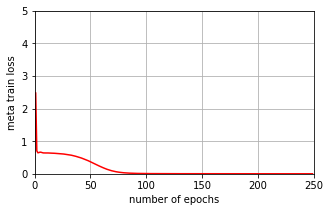

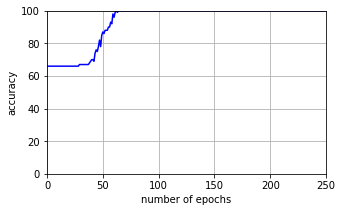

('colon_polyps_present', 'COADREAD')
test acc:71.0

Avg test acc:71.0


(71.0, {"('colon_polyps_present', 'COADREAD')": [0.71, 50, 100, 2]})

In [20]:
meta_epochs = 250
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size,num_shots)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiment 6: meta-epochs = 50, 70, meta_batch_size = 10

('colon_polyps_present', 'COADREAD')
('colon_polyps_present', 'COAD')
Train batch loss: 0.6614468097686768
Train batch acc: 68.5
('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
Train batch loss: 2.4674835205078125
Train batch acc: 68.5
('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
Train batch loss: 0.6571477651596069
Train batch acc: 68.5
('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
Train batch loss: 0.6313034296035767
Train batch acc: 68.5
('colon_polyps_present', 'COADREAD')
('colon_polyps_present', 'COAD')
Train batch loss: 0.6215947866439819
Train batch acc: 68.5
('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
Train batch loss: 0.6329233646392822
Train batch acc: 68.5
('colon_polyps_present', 'COADREAD')
('colon_polyps_present', 'COAD')
Train batch loss: 0.6339006423950195
Train batch acc: 68.5
('colon_polyps_present', 'COADREAD')
('colon_polyps_present', 'COAD')
Train batch loss: 0.6256219

Train batch loss: 0.48036643862724304
Train batch acc: 75.5
('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
Train batch loss: 0.47574543952941895
Train batch acc: 75.5
('colon_polyps_present', 'COAD')
('colon_polyps_present', 'COADREAD')
Train batch loss: 0.47116339206695557
Train batch acc: 75.5
('colon_polyps_present', 'COADREAD')
('colon_polyps_present', 'COAD')
Train batch loss: 0.46663230657577515
Train batch acc: 75.0
avg train loss with num_shots = 5 : 0.5972409248352051
avg train acc with num_shots = 5 : 70.40714263916016


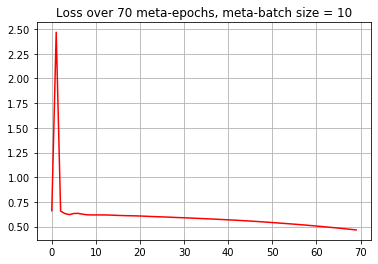

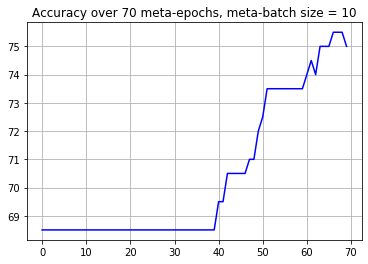

('colon_polyps_present', 'COADREAD')
test acc:76.0

Avg test acc:76.0


(76.0, {"('colon_polyps_present', 'COADREAD')": [0.76, 50, 100, 2]})

In [36]:
meta_epochs = 70
meta_batch_size = 10
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)

# Experiments trained on various tasks 

In [1]:
valid_tasks = filter_tasks(tasks)
ratio = int(0.8* len(valid_tasks))
meta_train_set = valid_tasks[:ratio]
meta_test_set = valid_tasks[ratio:]
print(len(meta_train_set), len(meta_test_set))

NameError: name 'filter_tasks' is not defined

In [ ]:
meta_epochs = 15
MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
optimizer= torch.optim.Adam(params=MLP_model.parameters(), lr=MLP_model.learning_rate)
trained_model, _, _, _, _ = meta_train(meta_train_set, optimizer, MLP_model, meta_epochs, meta_batch_size)
meta_test(trained_model, meta_test_set, optimizer, meta_batch_size)